In [65]:
#导入所需要的的库

import sys 
print("Python version: {}". format(sys.version))

import pandas as pd 
print("pandas version: {}". format(pd.__version__))

import matplotlib 
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display 
print("IPython version: {}". format(IPython.__version__)) 

import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
import time

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
pandas version: 0.25.1
matplotlib version: 3.1.1
NumPy version: 1.16.5
SciPy version: 1.3.1
IPython version: 7.8.0
scikit-learn version: 0.21.3
-------------------------


In [66]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [67]:
all_data = pd.concat([train, test], ignore_index = True)

In [68]:
'''数据清洗'''

'数据清洗'

In [69]:
'''1)缺失值填充
Age Feature：Age缺失量为263，缺失量较大，用Sex, Title, Pclass三个特征构建随机森林模型，填充年龄缺失值。'''

'1)缺失值填充\nAge Feature：Age缺失量为263，缺失量较大，用Sex, Title, Pclass三个特征构建随机森林模型，填充年龄缺失值。'

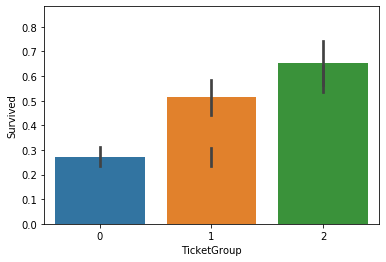

In [71]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data)
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

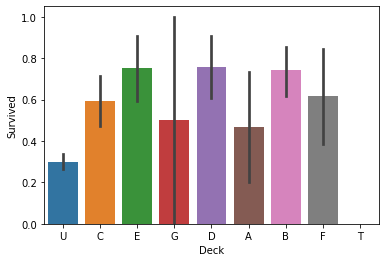

In [72]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck'] = all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data)

In [73]:
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

In [74]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)

In [75]:
all_data.count()

Age            1046
Cabin          1309
Embarked       1307
Fare           1308
Name           1309
Parch          1309
PassengerId    1309
Pclass         1309
Sex            1309
SibSp          1309
Survived        891
Ticket         1309
TicketGroup    1309
Deck           1309
Title          1309
FamilySize     1309
FamilyLabel    1309
dtype: int64

In [76]:
from sklearn.ensemble import RandomForestRegressor
age_df = all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges 

In [77]:
'''
Embarked Feature：Embarked缺失量为2，缺失Embarked信息的乘客的Pclass均为1，且Fare均为80，因为Embarked为C且Pclass为1的乘客的Fare中位数为80，所以缺失值填充为C。
'''

'\nEmbarked Feature：Embarked缺失量为2，缺失Embarked信息的乘客的Pclass均为1，且Fare均为80，因为Embarked为C且Pclass为1的乘客的Fare中位数为80，所以缺失值填充为C。\n'

In [78]:
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TicketGroup,Deck,Title,FamilySize,FamilyLabel
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,2,B,Miss,1,1
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,2,B,Mrs,1,1


In [79]:
all_data.groupby(by=["Pclass","Embarked"]).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [80]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [81]:
'''Fare Feature：Fare缺失量为1，缺失Fare信息的乘客的Embarked为S，Pclass为3，所以用Embarked为S，Pclass为3的乘客的Fare中位数填充。'''

'Fare Feature：Fare缺失量为1，缺失Fare信息的乘客的Embarked为S，Pclass为3，所以用Embarked为S，Pclass为3的乘客的Fare中位数填充。'

In [82]:
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TicketGroup,Deck,Title,FamilySize,FamilyLabel
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,1,U,Mr,1,1


In [83]:
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

In [84]:
#检查数据是否以及填充完毕
all_data.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
TicketGroup      0
Deck             0
Title            0
FamilySize       0
FamilyLabel      0
dtype: int64

In [85]:
'''2)同组识别
把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性。'''

'2)同组识别\n把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性。'

In [86]:
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

In [87]:
#发现绝大部分女性和儿童组的平均存活率都为1或0，即同组的女性和儿童要么全部幸存，要么全部遇难。

In [88]:
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5, 0, 'AverageSurvived')

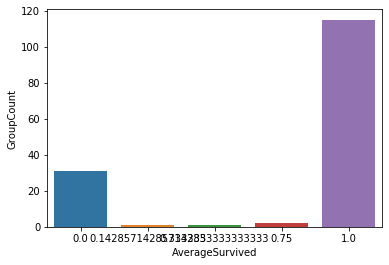

In [89]:
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"]).set_xlabel('AverageSurvived')

In [90]:
#绝大部分成年男性组的平均存活率也为1或0。

In [91]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


In [92]:
'''因为普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理。把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组，推测处于遇难组的女性和儿童幸存的可能性较低，处于幸存组的成年男性幸存的可能性较高。
'''

'因为普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理。把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组，推测处于遇难组的女性和儿童幸存的可能性较低，处于幸存组的成年男性幸存的可能性较高。\n'

In [93]:
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Lefebre', 'Ford', 'Bourke', 'Cacic', 'Van Impe', 'Canavan', 'Skoog', 'Arnold-Franchi', 'Caram', 'Jussila', 'Palsson', 'Rosblom', 'Sage', 'Zabour', 'Lahtinen', 'Turpin', 'Panula', 'Boulos', 'Rice', 'Robins', 'Olsson', 'Strom', 'Lobb', 'Danbom', 'Barbara', 'Attalah', 'Goodwin', 'Vander Planke', 'Ilmakangas', 'Oreskovic', 'Johnston'}
{'Duff Gordon', 'Nakid', 'Beane', 'Daly', 'Greenfield', 'Taylor', 'Harder', 'Jussila', 'Goldenberg', 'Dick', 'Frauenthal', 'Jonsson', 'Kimball', 'Chambers', 'Beckwith', 'Bishop', 'Frolicher-Stehli', 'Bradley', 'Cardeza', 'McCoy'}


In [94]:
'''为了使处于这两种反常组中的样本能够被正确分类，对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改。'''

'为了使处于这两种反常组中的样本能够被正确分类，对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改。'

In [95]:
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

In [96]:
'''3)特征转换
选取特征，转换为数值变量，划分训练集和测试集。'''

'3)特征转换\n选取特征，转换为数值变量，划分训练集和测试集。'

In [97]:
all_data.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
TicketGroup      0
Deck             0
Title            0
FamilySize       0
FamilyLabel      0
Surname          0
FamilyGroup      0
dtype: int64

In [98]:
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)

In [99]:
x = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

In [100]:
#4.建模和优化

In [101]:
'''1)参数优化
用网格搜索自动化选取最优参数，事实上我用网格搜索得到的最优参数是n_estimators = 28，max_depth = 6。但是参考另一篇Kernel把参数改为n_estimators = 26，max_depth = 6之后交叉验证分数和kaggle评分都有略微提升。
'''

'1)参数优化\n用网格搜索自动化选取最优参数，事实上我用网格搜索得到的最优参数是n_estimators = 28，max_depth = 6。但是参考另一篇Kernel把参数改为n_estimators = 26，max_depth = 6之后交叉验证分数和kaggle评分都有略微提升。\n'

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 9, 'classify__n_estimators': 20} 0.8781095163184026


In [103]:
#2)训练模型

In [104]:
from sklearn.pipeline import make_pipeline
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(x, y)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_classif at 0x00000220836519D8>)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=6,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=26, n_jobs=None,
                                        oob_score=False, random_state=10,
                                        verbose=0, warm_start=True))],
         verbose

In [105]:
#3)交叉验证

In [113]:
from sklearn import cross_validation, metrics
cv_score = cross_validation.cross_val_score(pipeline, x, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

ImportError: cannot import name 'cross_validation' from 'sklearn' (D:\Program Files\Anaconda3\lib\site-packages\sklearn\__init__.py)

In [109]:
#5.预测

In [115]:
test

,Pclass,Age,Fare,FamilyLabel,TicketGroup,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Title_the Countess,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
891,3,34.500000,7.8292,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
892,3,47.000000,7.0000,2,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
893,2,62.000000,9.6875,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
894,3,27.000000,8.6625,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
895,3,22.000000,12.2875,2,2,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,28.226256,8.0500,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1305,1,39.000000,108.9000,1,2,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1306,3,38.500000,7.2500,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1307,3,28.226256,8.0500,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [116]:
predictions = pipeline.predict(test)

In [119]:
predictions

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0.

In [124]:
test.columns

Index(['Pclass', 'Age', 'Fare', 'FamilyLabel', 'TicketGroup', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Capt',
       'Title_Col', 'Title_Don', 'Title_Dona', 'Title_Dr', 'Title_Jonkheer',
       'Title_Lady', 'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle',
       'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev',
       'Title_Sir', 'Title_the Countess', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U'],
      dtype='object')

In [125]:
train.columns

Index(['Survived', 'Pclass', 'Age', 'Fare', 'FamilyLabel', 'TicketGroup',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Capt', 'Title_Col', 'Title_Don', 'Title_Dona', 'Title_Dr',
       'Title_Jonkheer', 'Title_Lady', 'Title_Major', 'Title_Master',
       'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs',
       'Title_Ms', 'Title_Rev', 'Title_Sir', 'Title_the Countess', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Deck_U'],
      dtype='object')

In [126]:
test = pd.read_csv('test.csv')

In [127]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [128]:
result = pd.DataFrame({'PassengerId':test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})

In [131]:
result.to_csv(r"submission.csv", index=False)